In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [2]:
from optimization_target import target_func, FUNC_DOMAIN, FUNC_RANGE, TUNABLE_PARAM_NAME, METRIC_NAME

In [3]:
print(f"x: target_func domain = {FUNC_DOMAIN} :: {TUNABLE_PARAM_NAME}")
print(f"y: target_func range  = {FUNC_RANGE} :: {METRIC_NAME}")

x: target_func domain = (0, 1000000) :: sched_migration_cost_ns
y: target_func range  = (0.2, 1.8) :: Latency, ms


In [4]:
NUM_SAMPLES = 10

np.random.seed(42)

In [5]:
# df = pandas.DataFrame({"x": [], "y": []})
df = pandas.DataFrame({"x": np.random.uniform(0, 1000000, NUM_SAMPLES).tolist() + [500000]})
df["y"] = df.x.apply(target_func)
df

,x,y
0,374540.118847,0.680795
1,950714.306410,1.373329
2,731993.941811,0.726630
3,598658.484197,0.652248
4,156018.640442,0.645717
5,155994.520336,0.645547
6,58083.612168,0.683273
7,866176.145775,1.099371
8,601115.011743,0.644523
9,708072.577796,0.715542


In [6]:
num_prior_samples = 100
prior_x = np.linspace(-200000, 1200000, num_prior_samples).reshape(-1, 1)
prior_y = np.ones(num_prior_samples) * 2.47
prior_alpha = np.ones(num_prior_samples) * 4.0

x = np.concatenate([prior_x, df.x.to_numpy().reshape(-1, 1)])
y = np.concatenate([prior_y, df.y.to_numpy()])
alpha = np.concatenate([prior_alpha, np.ones(len(df.y)) * 0.0])

# x = prior_x
# y = prior_y
# alpha = prior_alpha

kernel1 = RBF(length_scale=80000, length_scale_bounds="fixed")
gp1 = GaussianProcessRegressor(kernel=kernel1, alpha=alpha, random_state=42).fit(x, y)

kernel2 = RBF(length_scale=20000, length_scale_bounds="fixed")
gp2 = GaussianProcessRegressor(kernel=kernel2, alpha=alpha, random_state=42).fit(x, y)

kernel3 = RBF(length_scale=150000, length_scale_bounds="fixed")
gp3 = GaussianProcessRegressor(kernel=kernel3, alpha=alpha, random_state=42).fit(x, y)


Check out https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html

In [7]:
colors_dark2 = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]

num_sample_funcs = 3

/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:479: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


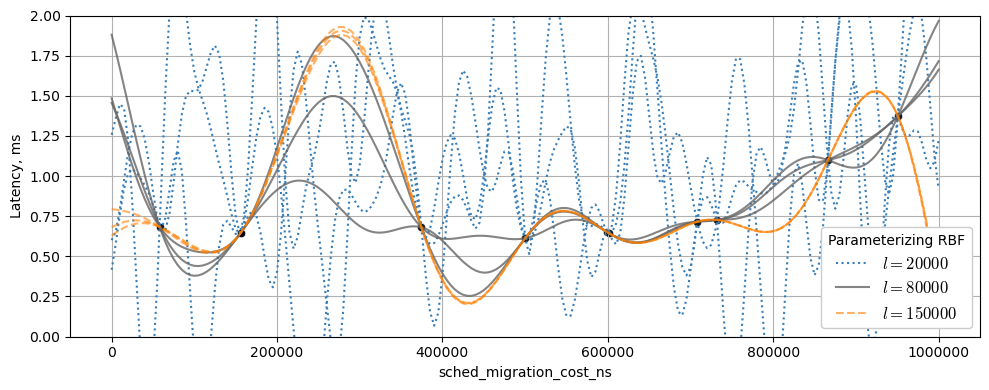

In [8]:
plt.rcParams["figure.figsize"] = (10, 4)

_fig, ax = plt.subplots()

sns.scatterplot(data=df, x="x", y="y", marker='o', color="black", alpha=0.9, legend=False)

x = np.linspace(0, 1000000, 201).reshape(-1, 1)

# --- GP2

y = gp2.sample_y(x, n_samples=num_sample_funcs, random_state=41)
y_mean, y_std = gp2.predict(x, return_std=True)

for i in range(num_sample_funcs):
    kw = {"legend": True, "label": f"$l={kernel2.length_scale}$"} if i == 0 else {}
    sns.lineplot(x=x[:,0], y=y[:,i], color="#377eb8", alpha=1, linestyle=":", **kw)

# sns.lineplot(x=x[:,0], y=y_mean, color=colors_dark2[2], alpha=0.7, legend=True)
# plt.fill_between(x[:,0], y_mean - y_std, y_mean + y_std, alpha=0.2, color=colors_dark2[2])

# --- GP1

y = gp1.sample_y(x, n_samples=num_sample_funcs, random_state=41)
y_mean, y_std = gp1.predict(x, return_std=True)

for i in range(num_sample_funcs):
    kw = {"legend": True, "label": f"$l={kernel1.length_scale}$"} if i == 0 else {}
    sns.lineplot(x=x[:,0], y=y[:,i], color="#666666", alpha=0.8, **kw)

# sns.lineplot(x=x[:,0], y=y_mean, color=colors_dark2[1], alpha=0.7)
# plt.fill_between(x[:,0], y_mean - y_std, y_mean + y_std, alpha=0.2, color=colors_dark2[1])

# --- GP3

y = gp3.sample_y(x, n_samples=num_sample_funcs, random_state=41)
y_mean, y_std = gp3.predict(x, return_std=True)

for i in range(num_sample_funcs):
    kw = {"legend": True, "label": f"$l={kernel3.length_scale}$"} if i == 0 else {}
    sns.lineplot(x=x[:,0], y=y[:,i], color="#ff7f00", alpha=0.6, linestyle="--", **kw)

# sns.lineplot(x=x[:,0], y=y_mean, color=colors_dark2[2], alpha=0.7, legend=True)
# plt.fill_between(x[:,0], y_mean - y_std, y_mean + y_std, alpha=0.2, color=colors_dark2[2])

# -------

plt.xlim(-50000, 1050000)
plt.ylim(0, 2)

plt.ticklabel_format(axis="both", style="plain")

plt.xlabel(TUNABLE_PARAM_NAME)
plt.ylabel(METRIC_NAME)

plt.grid()
plt.legend(title="Parameterizing RBF", loc="lower right",
           facecolor='white', framealpha=1, prop={'size': 12, "math_fontfamily": 'cm'})
plt.tight_layout()

plt.savefig("img/sigmod2025_tutorial_04_kernel_01_rbf.png", transparent=False, dpi=300)

plt.show()
# display(y_mean)